# Objective

This file explores different machine learning models to select the highest accuracy model for college football win predictions. The best model is saved to the output `cfb_model.joblib`.

## Import Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Principle Component Analysis
from sklearn.decomposition import PCA

# Train Test Split
from sklearn.model_selection import train_test_split

# Classification Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Accuracy Scoring
from sklearn.metrics import accuracy_score

# Grid Search Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Model Saving
import joblib

# Paths
from pathlib import Path

/Users/mattcallicott/opt/anaconda3/envs/playground/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Load Data

Loads and concatenates data from each year. Saved as `X` for feature space, `y` for outcome. 

In [2]:
p = Path(r'data/').glob('**/*')
files = [x.name for x in p if x.is_file()]

X_files = [x for x in files if 'X_' in x][::-1]
y_files = [y for y in files if 'y_' in y][::-1]

In [3]:
def load_modeling_data(files: list) -> pd.DataFrame:

	df = None

	for file in files:

		file_df = pd.read_csv(f'data/{file}')

		if df is None:
			df = file_df
		else:
			df = pd.concat((df, file_df))
	
	return df.reset_index(drop=True)

In [4]:
X = load_modeling_data(X_files)
y = load_modeling_data(y_files)

## Feature Importances

To provide value to college football teams in terms of what they can control to change the outcome of a game, a feature importance chart was created using the random forest trained above. `rush_yds_home_def` (the average rushing yards the home team's defense allows per game) is the most imporant feature at the time of writing this.

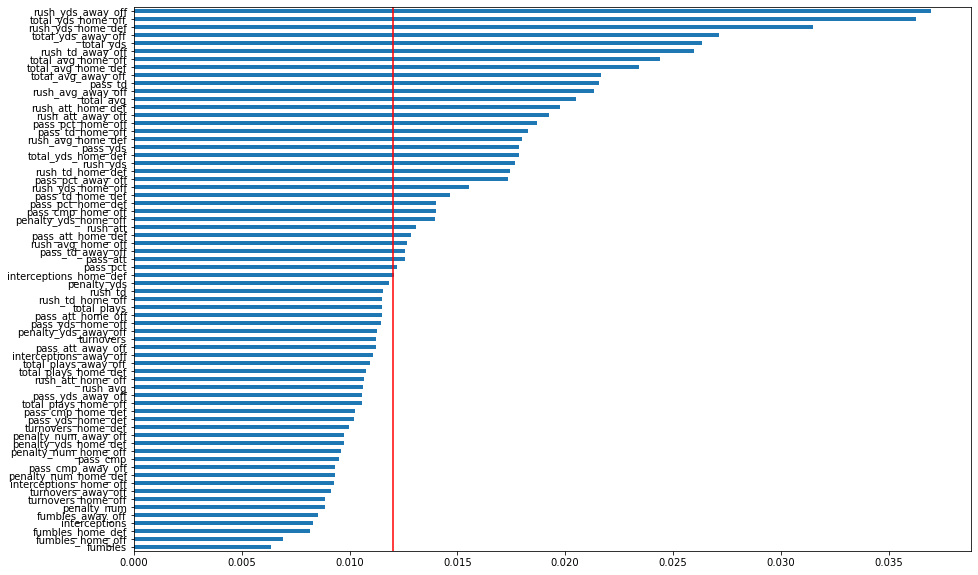

In [5]:
feature_selection_model = RandomForestClassifier()
feature_selection_model.fit(X, y)

feature_importances = pd.Series(feature_selection_model.feature_importances_, index=X.columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(15, 10))

feature_importances.plot(kind='barh', ax=ax)

threshold = 0.012 # 0.012 set as an arbitrary cutoff given the data

ax.axvline(threshold, color='red') 

plt.show()

important_features = feature_importances[feature_importances > threshold].index

X_important_features = X[important_features]

## PCA

Principle component analysis performed to increase model performance. PCA fitted with `X_important_features` feature space. Explained variance ratios showed, with a clear elbow at PCA 8/9, indicating the use of 8-9 principle components. 

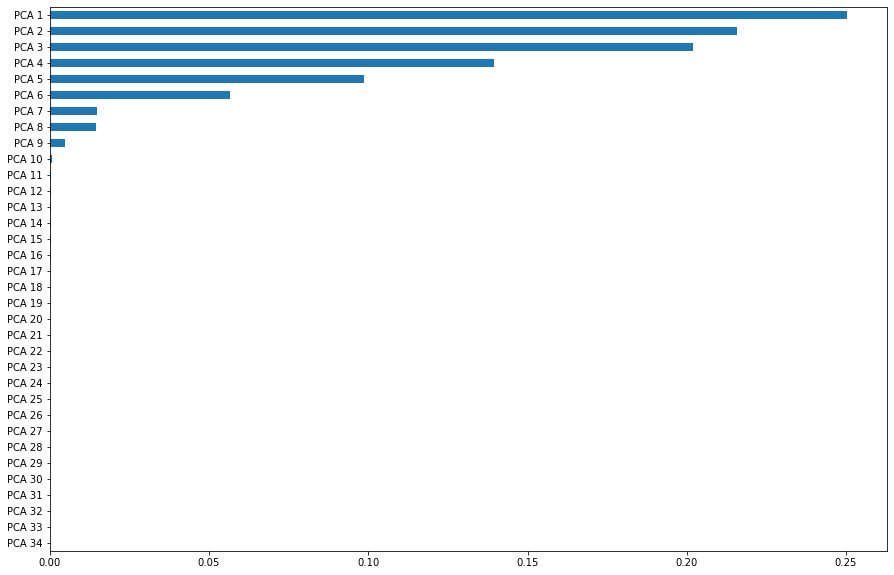

In [6]:
pca = PCA().fit(X_important_features)

X_pca = pca.transform(X_important_features)

pca_variances = pd.Series(pca.explained_variance_ratio_, index=[f'PCA {i}' for i in range(1, X_important_features.shape[1] + 1)]).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(15, 10))
pca_variances.plot(kind='barh', ax=ax)
plt.show()

# Limit to 9 principle components
X_pca = X_pca[:, :9]

## Training and Testing Data Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Model Exploration

Several different classification models were used to determine the best (try all approach). 

The most accurate model was Logisitic Regression. 

In [8]:
models = {
	'Logistic Regression': LogisticRegression(),
	'Random Forest': RandomForestClassifier(),
	'KNN': KNeighborsClassifier(),
	'SVC': SVC(probability=True)
}

for name, model in models.items():
	model.fit(X_train, y_train['outcome'])
	print(f"{name}:  {round(accuracy_score(y_test['outcome'], model.predict(X_test)), 3)}")

Logistic Regression:  0.763
Random Forest:  0.696
KNN:  0.731
SVC:  0.756


## Hyper-Parameter Tuning

Tuning Logistic Regression model using grid search cross validation. Best model is saved as `clf` and exported to `cfb_model.joblib`.

In [9]:
lr_params = {
	'C': np.logspace(-3,3,7),
	'penalty': ['l1','l2'], 
    	'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(), lr_params, scoring='accuracy', cv=10)

grid.fit(X_train, y_train)

print(f"Best parameters for logistic regression: {grid.best_params_}")
print(f"Best score for logistic regression: {grid.best_score_}")

clf = grid.best_estimator_

joblib.dump(clf, 'models/cfb_lr_model.joblib')

Best parameters for logistic regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for logistic regression: 0.7560606060606061


['models/cfb_lr_model.joblib']

In [11]:
svc_params = {
	'C': [0.0001, 0.001, 0.1],
    	'kernel': ['linear', 'rbf'],
	'probability': [True]
}

grid = GridSearchCV(SVC(), svc_params, scoring='accuracy', cv=10)

grid.fit(X_train, y_train)

print(f"Best parameters for SVC: {grid.best_params_}")
print(f"Best score for SVC: {grid.best_score_}")

clf = grid.best_estimator_

joblib.dump(clf, 'models/cfb_svc_model.joblib')

Best parameters for SVC: {'C': 0.001, 'kernel': 'linear', 'probability': True}
Best score for SVC: 0.753030303030303


['models/cfb_svc_model.joblib']